### Signal to Noise Calculations

The SNR is calculated following the equation (see, e.g., pg 407 of "Spectroscopic Instrumentation" by Eversberg and Vollmann): 

$SNR = \frac{I t}{\sqrt{I t + B t + D t + R^2}}$, 

where I is the signal over some number of pixels, B is the sky background over some number of pixels, D is the dark current over some number of pixels and R is the readout noise of the detector.  The exposure time, t, is usually given in seconds.

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

machine = 'chinook'

In [11]:
def getBackgroundMean(start,end):
    wavelength = []
    flux = []
    if machine=='coho':
        backgrounddir = '/Users/deblokhorst/Documents/Dragonfly/DragonflyHalpha/Notebooks/'
    elif machine=='chinook':
        backgrounddir = '/Users/lokhorst/Documents/HalphaScripts/'
    with open(backgrounddir+'Gemini_skybackground.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    total=0
    for index in np.arange(start_ind,end_ind):
        total = total + (flux[index]*(wavelength[index+1]-wavelength[index]))
    
    return total /(wavelength[end_ind]-wavelength[start_ind])

In [12]:
area_lens = np.pi*(14.3/2)**2 * 48. * u.cm**2               # 48 * 14.3 cm diameter lenses
pix_size = 2.8                                              # arcsec
ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD
# transmittance of the Dragonfly lens
tau_l = 0.85  
# quantum efficiency of the CCDs
QE_new = 0.70 
QE_old = 0.48 
# transmittance of the Halpha filter -- assumed for now
tau_f = 1.    

#### The following are per pixel ###
# sky background at 565.6 nm 
B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2  
# dark current (electrons / s) -- PER PIXEL??
D = 0.04 *u.photon/u.second                             
# read noise (electrons)
R_squared_old = 10.**2 * u.photon 
R_squared_new = 1.**2 * u.photon 

In [16]:
filterwidth_5 = 0.7657* u.nm 
B_5 = getBackgroundMean(656.3,657.0657)*u.photon/u.second/u.nm/u.arcsec**2/u.m**2
print('Background avg in 0.77nm: '+str(B_5))

B_tot = B * QE * tau_l * tau_f * filterwidth_5 * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
#print(B)
#print(B* filterwidth_5)
#print(B* filterwidth_5* ang_size_pixel.to(u.arcsec**2))
#print(area_lens)
#print(area_lens.to(u.m**2))
print('Background total in 0.77nm: '+str(B_tot))

Background avg in 0.77nm: 0.519773417722 ph / (arcsec2 m2 nm s)
Background total in 0.77nm: 0.984388719975 ph / s


In [17]:
R_squared = R_squared_old
QE = QE_old

# 5 Mpc bandpass means...
filterwidth_5 = 0.7657* u.nm 
B_5 = getBackgroundMean(656.3,657.0657)*u.photon/u.second/u.nm/u.arcsec**2/u.m**2
print('Background avg in 0.77nm: '+str(B_5))

# 3 nm bandpass
filterwidth_3nm = 3.0 * u.nm
B_3nm = getBackgroundMean(656.3,659.3)*u.photon/u.second/u.nm/u.arcsec**2/u.m**2
print('Background avg in 3nm: '+str(B_3nm))

B = B_3nm
filterwidth = filterwidth_3nm

numpixels= np.array([(100.*100.)/(pix_size**2),(10.*10.)/(pix_size**2),1.])
numpixel = 100.0 * 100.0/(pix_size**2)   # 100-arcsec-a-side pixels

SB_ph_one = 10**-2. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_two = 10**-1. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_thr = 10**0. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_fou = 10**1. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_fiv = 10**2. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_six = 10**3. * u.photon / (u.cm**2 * u.rad**2 * u.second)

def calcSNR(SB_ph,time):
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    B_tot = B * QE * tau_l * tau_f * filterwidth * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    print('total S: %s'%S)
    print('total B: %s'%B_tot)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)
    SNR = signal/sigma
    return SNR

# SB_ph_one
time = 60.*60*800000000000. * u.second
SNR = calcSNR(SB_ph_one,time)

print('SB: '+str(SB_ph_one))
print('numpixel:'+str(numpixel))
print('time (hours): '+str(time/(3600.*u.second)))
print('SNR: '+str(SNR))

time_1_array = np.arange(1,time.value,100000000)* u.second
print('The length of time_1_array is %s'%(len(time_1_array)))
print('\n')

# SB_ph_two 
time = 60.*60*8000000000. * u.second
SNR = calcSNR(SB_ph_two,time)

print('SB: '+str(SB_ph_two))
print('numpixel:'+str(numpixel))
print('time (hours): '+str(time/(3600.*u.second)))
print('SNR: '+str(SNR))

time_2_array = np.arange(1,time.value,10000000)* u.second
print('The length of time_2_array is %s'%(len(time_2_array)))
print('\n')

# SB_ph_thr 
time = 60.*60*100000000. * u.second  #  For the large box
#time = 60.*60*10000. * u.second    #  For the small box
SNR = calcSNR(SB_ph_thr,time)

print('SB: '+str(SB_ph_thr))
print('numpixel:'+str(numpixel))
print('time (hours): '+str(time/(3600.*u.second)))
print('SNR: '+str(SNR))

time_3_array = np.arange(1,time.value,100000)* u.second
print('The length of time_3_array is %s'%(len(time_3_array)))
print('\n')

# SB_ph_fou --> 
time = 60.*60*1000000. * u.second  #  For the large box
#time = 60.*60*10000. * u.second    #  For the small box
SNR = calcSNR(SB_ph_fou,time)

print('SB: '+str(SB_ph_fou))
print('numpixel:'+str(numpixel))
print('time (hours): '+str(time/(3600.*u.second)))
print('SNR: '+str(SNR))

time_4_array = np.arange(1,time.value,100)* u.second
print('The length of time_4_array is %s'%(len(time_4_array)))
print('\n')

# SB_ph_fiv --> 
time = 60.*60*1300. * u.second  #  For ~1nm filter (B_5,filterwidth_5)
time = 60.*60*6000. * u.second  #  For 3nm filter (B_3nm,filterwidth_3nm)
SNR = calcSNR(SB_ph_fiv,time)

print('SB: '+str(SB_ph_fiv))
print('numpixel:'+str(numpixel))
print('time (hours): '+str(time/(3600.*u.second)))
print('SNR: '+str(SNR))

time_5_array = np.arange(1,time.value,1)* u.second
print('The length of time_5_array is %s'%(len(time_5_array)))
print('\n')

# SB_ph_six --> 
time = 60.*60*13. * u.second  #  For ~1nm filter (B_5,filterwidth_5)
time = 60.*60*60 * u.second   #  For 3nm filter (B_3nm,filterwidth_3nm)
SNR = calcSNR(SB_ph_six,time)

print('SB: '+str(SB_ph_six))
print('numpixel:'+str(numpixel))
print('time (hours): '+str(time/(3600.*u.second)))
print('SNR: '+str(SNR))

time_6_array = np.arange(1,time.value,1)* u.second
print('The length of time_6_array is %s'%(len(time_5_array)))
print('\n')

Background avg in 0.77nm: 0.519773417722 ph / (arcsec2 m2 nm s)
Background avg in 3nm: 0.504666438356 ph / (arcsec2 m2 nm s)
total S: 5.79599947142e-09 ph / s
total B: 3.73339792907 ph / s
SB: 0.01 ph / (cm2 rad2 s)
numpixel:1275.51020408
time (hours): 8e+11
SNR: 5.71873860457 ph(1/2)
The length of time_1_array is 28800000


total S: 5.79599947142e-08 ph / s
total B: 3.73339792907 ph / s
SB: 0.1 ph / (cm2 rad2 s)
numpixel:1275.51020408
time (hours): 8000000000.0
SNR: 5.71873856504 ph(1/2)
The length of time_2_array is 2880000


total S: 5.79599947142e-07 ph / s
total B: 3.73339792907 ph / s
SB: 1.0 ph / (cm2 rad2 s)
numpixel:1275.51020408
time (hours): 100000000.0
SNR: 6.39374364632 ph(1/2)
The length of time_3_array is 3600000


total S: 5.79599947142e-06 ph / s
total B: 3.73339792907 ph / s
SB: 10.0 ph / (cm2 rad2 s)
numpixel:1275.51020408
time (hours): 1000000.0
SNR: 6.39373920363 ph(1/2)
The length of time_4_array is 36000000


total S: 5.79599947142e-05 ph / s
total B: 3.733397929

Halpha Signal: 5.79599947142e-09 ph / s
Background Sky: 0.774957274111 ph / s
Halpha Signal: 5.79599947142e-08 ph / s
Background Sky: 7.74957274111 ph / s
Halpha Signal: 5.79599947142e-08 ph / s
Background Sky: 0.774957274111 ph / s
Halpha Signal: 5.79599947142e-07 ph / s
Background Sky: 7.74957274111 ph / s
Halpha Signal: 5.79599947142e-07 ph / s
Background Sky: 0.774957274111 ph / s
Halpha Signal: 5.79599947142e-06 ph / s
Background Sky: 7.74957274111 ph / s
Halpha Signal: 5.79599947142e-06 ph / s
Background Sky: 0.774957274111 ph / s
Halpha Signal: 5.79599947142e-05 ph / s
Background Sky: 7.74957274111 ph / s
Halpha Signal: 5.79599947142e-05 ph / s
Background Sky: 0.774957274111 ph / s
Halpha Signal: 0.000579599947142 ph / s
Background Sky: 7.74957274111 ph / s
mostly with number of pixels: 127551.020408


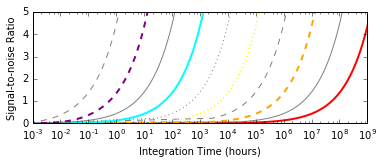

In [22]:
plt.figure(figsize=(6,2))

numpixel = 1000.0 * 1000.0/(pix_size**2)   # 1000-arcsec-a-side pixels
#numpixel = 100.0 * 100.0/(pix_size**2)   # 1000-arcsec-a-side pixels


#numpixel = (330.*330.)/(2.8*2.8) 

filterwidth=filterwidth_5
SB_array = [SB_ph_one,SB_ph_two,SB_ph_thr,SB_ph_fou,SB_ph_fiv]
area_lens_500 = area_lens * 10.
timearray = [time_1_array,time_2_array,time_3_array,time_4_array,time_5_array]
symbols = ['k-','k--','k:','k-','k--']
colors = ['red','orange','yellow','cyan','purple']
for SB_ph,time,symbol,color in zip(SB_array,timearray,symbols,colors):
    
    ################### 48 lenses
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    B_tot = B * QE * tau_l * tau_f * filterwidth * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal: IS THIS TRUE HERE?
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    plt.semilogx((time/3600./u.second), (signal/sigma/(u.photon**0.5)),symbol,linewidth=2,color=color)

    ################### 480 lenses
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens_500 * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    B_tot = B * QE * tau_l * tau_f * filterwidth * area_lens_500.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    plt.semilogx((time/3600./u.second), (signal/sigma/(u.photon**0.5)),symbol,linewidth=1,color ='grey')
print('mostly with number of pixels: '+str(numpixel))

#numpixel = (330.*330.)/(2.8*2.8) 
#time = time_3_array
#S = SB_ph_thr * QE * tau_l * tau_f * area_lens_500 * ang_size_pixel
#signal = S*time*numpixel
#B_tot = B * QE * tau_l * tau_f * filterwidth * area_lens_500.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
#sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)
#plt.semilogx((time/3600./u.second), (signal/sigma/(u.photon**0.5)),'k-',linewidth=3,color ='yellow')
#print('extra line with number of pixels: '+str(numpixel))

plt.ylim(0,5)
plt.xlim(10**-3,10**9)
#plt.xticks([-2,0,2,4,6,8],['10$^{-2}$','10$^{0}$','10$^{2}$','10$^{4}$','10$^{6}$','10$^{8}$'])

plt.plot([10**-3,10**9],[5,5],color='gray')
plt.xlabel('Integration Time (hours)')
plt.ylabel('Signal-to-noise Ratio')
plt.savefig('plots/SignalToNoise_Contours_QE_%s_Rsquared_%s_withnumpix_%s_shorter.pdf'%(QE,R_squared.value,numpixel),bbox_inches='tight')

Plot with less lines.

Halpha Signal: 5.79599947142e-05 ph / s
Background Sky: 0.952887598097 ph / s
Halpha Signal: 0.000579599947142 ph / s
Background Sky: 9.52887598097 ph / s
Halpha Signal: 5.79599947142e-07 ph / s
Background Sky: 0.952887598097 ph / s
Halpha Signal: 5.79599947142e-06 ph / s
Background Sky: 9.52887598097 ph / s
mostly with number of pixels: 13890.3061224


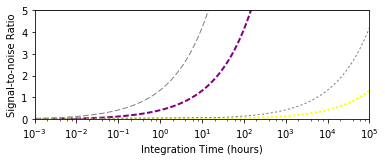

In [39]:
plt.figure(figsize=(6,2))

numpixel = 1000.0 * 1000.0/(pix_size**2)   # 1000-arcsec-a-side pixels
numpixel = 100.0 * 100.0/(pix_size**2)   # 1000-arcsec-a-side pixels
numpixel = (330.*330.)/(pix_size**2)     # 330-arcsec-a-side pixels 

filterwidth=filterwidth_5
SB_array = [SB_ph_one,SB_ph_two,SB_ph_thr,SB_ph_fou,SB_ph_fiv]
area_lens_500 = area_lens * 10.
timearray = {SB_ph_one:time_1_array,SB_ph_two:time_2_array,
             SB_ph_thr:time_3_array,SB_ph_fou:time_4_array,SB_ph_fiv:time_5_array}
symbols = {SB_ph_one:'k-',SB_ph_two:'k--',SB_ph_thr:'k:',SB_ph_fou:'k-',SB_ph_fiv:'k--'}
colors = {SB_ph_one:'red',SB_ph_two:'orange',SB_ph_thr:'yellow',SB_ph_fou:'cyan',SB_ph_fiv:'purple'}

for SB_ph in [SB_ph_fiv,SB_ph_thr]:
    time   = timearray[SB_ph]
    symbol = symbols[SB_ph]
    color  = colors[SB_ph]
    
    ################### 48 lenses
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    B_tot = B * QE * tau_l * tau_f * filterwidth * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal: IS THIS TRUE HERE?
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    plt.semilogx((time/3600./u.second), (signal/sigma/(u.photon**0.5)),symbol,linewidth=2,color=color)

    ################### 480 lenses
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens_500 * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    B_tot = B * QE * tau_l * tau_f * filterwidth * area_lens_500.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    plt.semilogx((time/3600./u.second), (signal/sigma/(u.photon**0.5)),symbol,linewidth=1,color ='grey')
print('mostly with number of pixels: '+str(numpixel))

#numpixel = (330.*330.)/(2.8*2.8) 
#time = time_3_array
#S = SB_ph_thr * QE * tau_l * tau_f * area_lens_500 * ang_size_pixel
#signal = S*time*numpixel
#B_tot = B * QE * tau_l * tau_f * filterwidth * area_lens_500.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
#sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)
#plt.semilogx((time/3600./u.second), (signal/sigma/(u.photon**0.5)),'k-',linewidth=3,color ='yellow')
#print('extra line with number of pixels: '+str(numpixel))

plt.ylim(0,5)
plt.xlim(10**-3,10**5)
#plt.xticks([-2,0,2,4,6,8],['10$^{-2}$','10$^{0}$','10$^{2}$','10$^{4}$','10$^{6}$','10$^{8}$'])

plt.plot([10**-3,10**9],[5,5],color='gray')
plt.xlabel('Integration Time (hours)')
plt.ylabel('Signal-to-noise Ratio')

In [19]:
# 1000" pixel a side:  number of pixels=127551.020408
# 100"  pixel a side:  number of pixels=1275.51020408

In [35]:
SB_array = [SB_ph_one,SB_ph_two,SB_ph_thr,SB_ph_fou,SB_ph_fiv]
area_lens_500 = area_lens * 10.
timearray = {SB_ph_one:time_1_array,SB_ph_two:time_2_array,
             SB_ph_thr:time_3_array,SB_ph_fou:time_4_array,SB_ph_fiv:time_5_array}
symbols = {SB_ph_one:'k-',SB_ph_two:'k--',SB_ph_thr:'k:',SB_ph_fou:'k-',SB_ph_fiv:'k--'}
colors = {SB_ph_one:'red',SB_ph_two:'orange',SB_ph_thr:'yellow',SB_ph_fou:'cyan',SB_ph_fiv:'purple'}
time   = timearray[SB_ph_two]
print time
print time_3_array

[  1.00000000e+00   1.00000010e+07   2.00000010e+07 ...,   2.87999700e+13
   2.87999800e+13   2.87999900e+13] s
[  1.00000000e+00   1.00001000e+05   2.00001000e+05 ...,   3.59999700e+11
   3.59999800e+11   3.59999900e+11] s
